## Setup

In [1]:
%matplotlib inline

#### The usual imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import itertools

#### Sklearn

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC, SVC

#### Load the dataset

In [4]:
dataset = pd.read_csv("adult.csv")
print(dataset.shape)
print()
print(dataset.columns.values)

(32561, 15)

['age' 'workclass' 'fnlwgt' 'education' 'education.num' 'marital.status'
 'occupation' 'relationship' 'race' 'sex' 'capital.gain' 'capital.loss'
 'hours.per.week' 'native.country' 'income']


## Lets explore some features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111e9a208>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1129ed5f8>]], dtype=object)

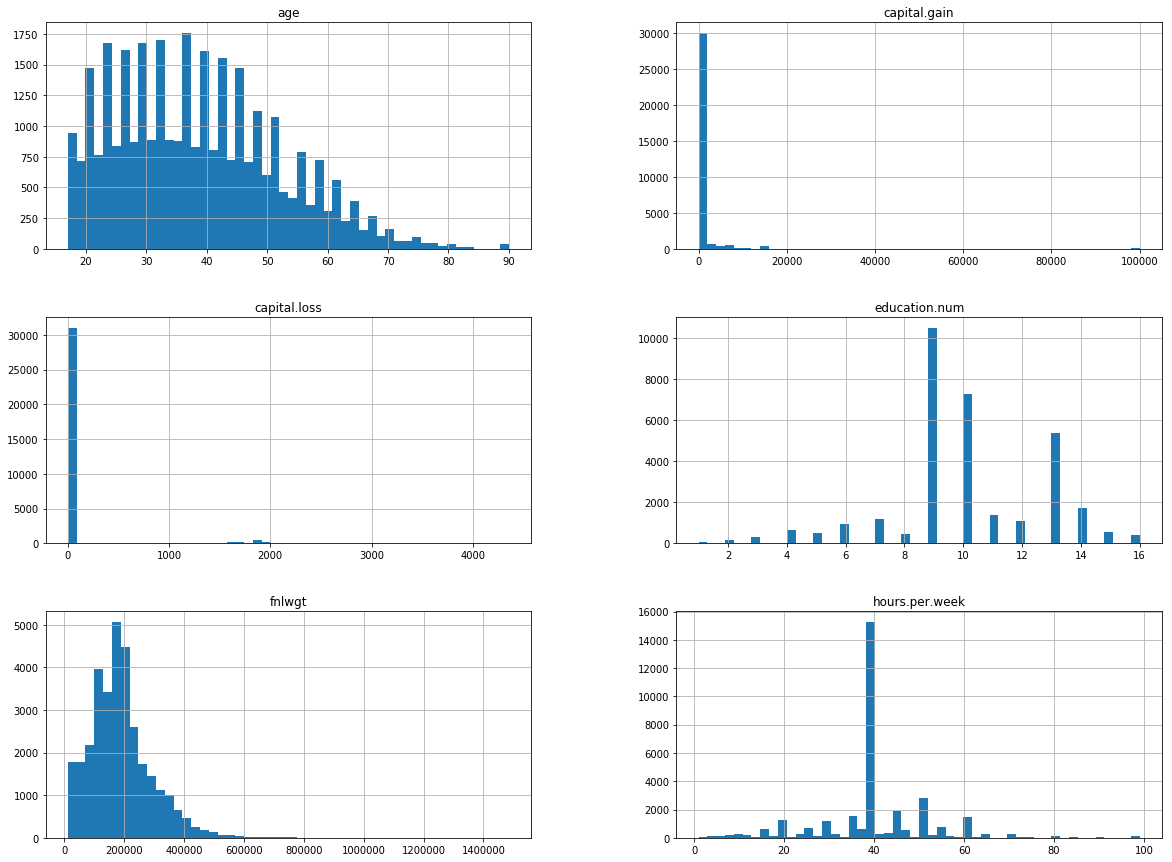

In [5]:
dataset.hist(bins=50, figsize=(20,15))

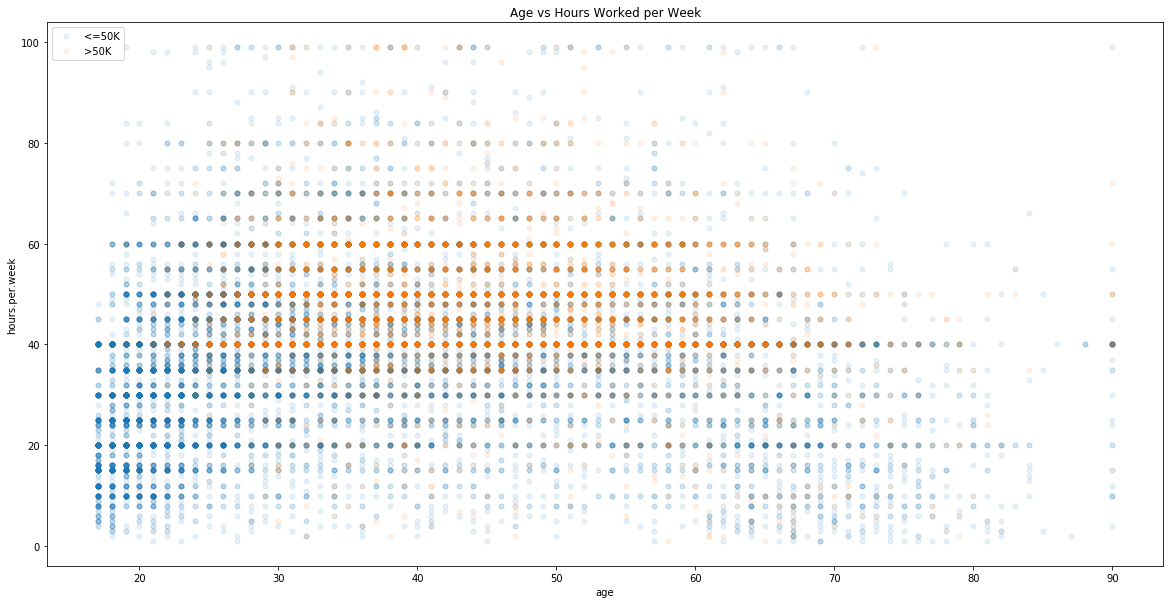

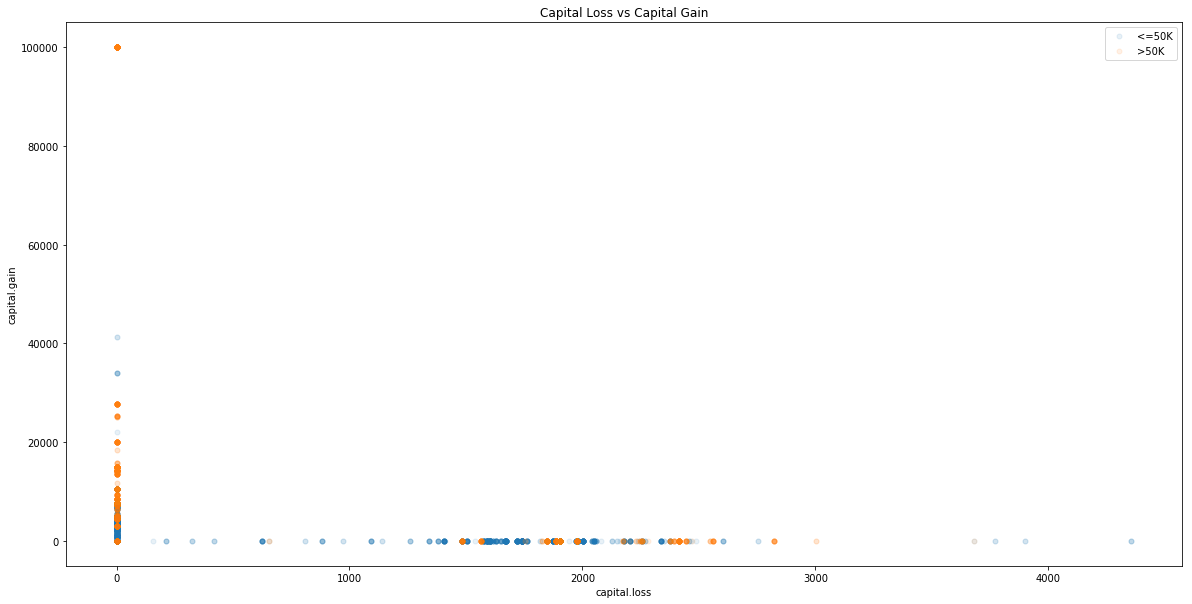

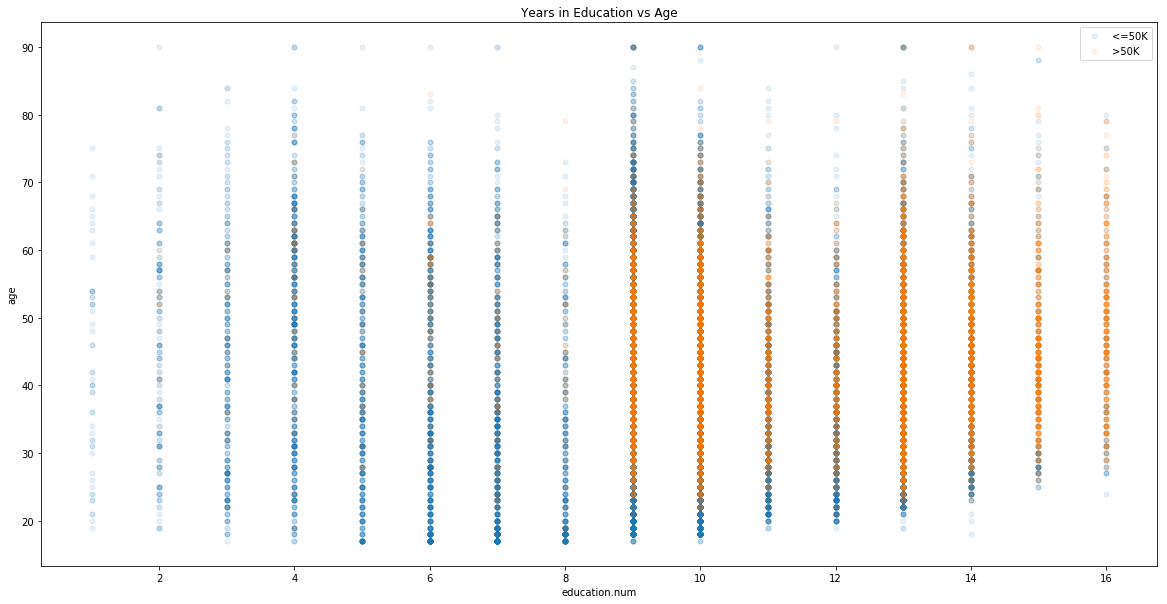

In [6]:
def createScatterSubPlot(x_feature, y_feature):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    for name, group in dataset.groupby('income'):
        ax.plot(group[x_feature], group[y_feature], marker='o', linestyle='', ms=5, label=name, alpha=0.1)
    ax.legend()
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)

createScatterSubPlot("age", "hours.per.week")
plt.title('Age vs Hours Worked per Week')
createScatterSubPlot("capital.loss", "capital.gain")
plt.title('Capital Loss vs Capital Gain')
createScatterSubPlot("education.num", "age")
plt.title('Years in Education vs Age')

plt.show()

In summary, most people earning >50k have 9 years or more of education, are aged between around 25 and 60, work atleast 40 hours per week, and have experienced little capital loss.

### Lets see how our dataset is divided

{'<=50K': 24720, '>50K': 7841}



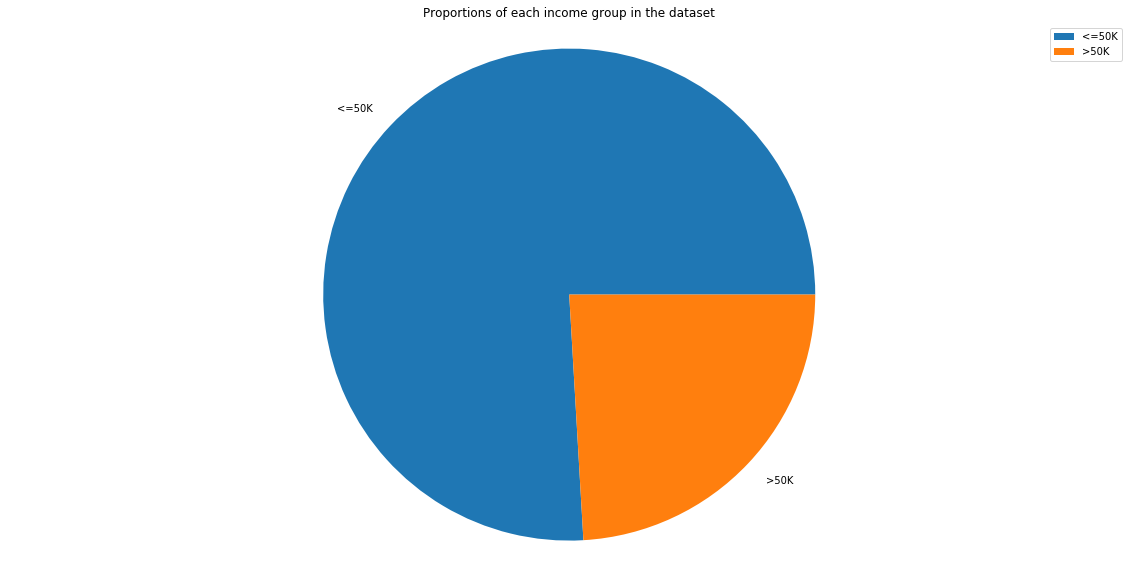

In [7]:
incomeCategories = dict()
for key in ["<=50K", ">50K"]:
    incomeCategories[key] = int(dataset[dataset.income == key].shape[0])
 
print(incomeCategories)

print()

fig, ax = plt.subplots(figsize=(20, 10))
ax.pie(list(incomeCategories.values()), labels=incomeCategories.keys())
ax.legend()
ax.axis('equal') 
plt.title('Proportions of each income group in the dataset')
plt.show()

Over 75% of the dataset fall into the <=50k category. This is important to remember when we are later assessing the performance of our model.

{'<=50K': {'Male': 15128, 'Female': 9592}, '>50K': {'Male': 6662, 'Female': 1179}}


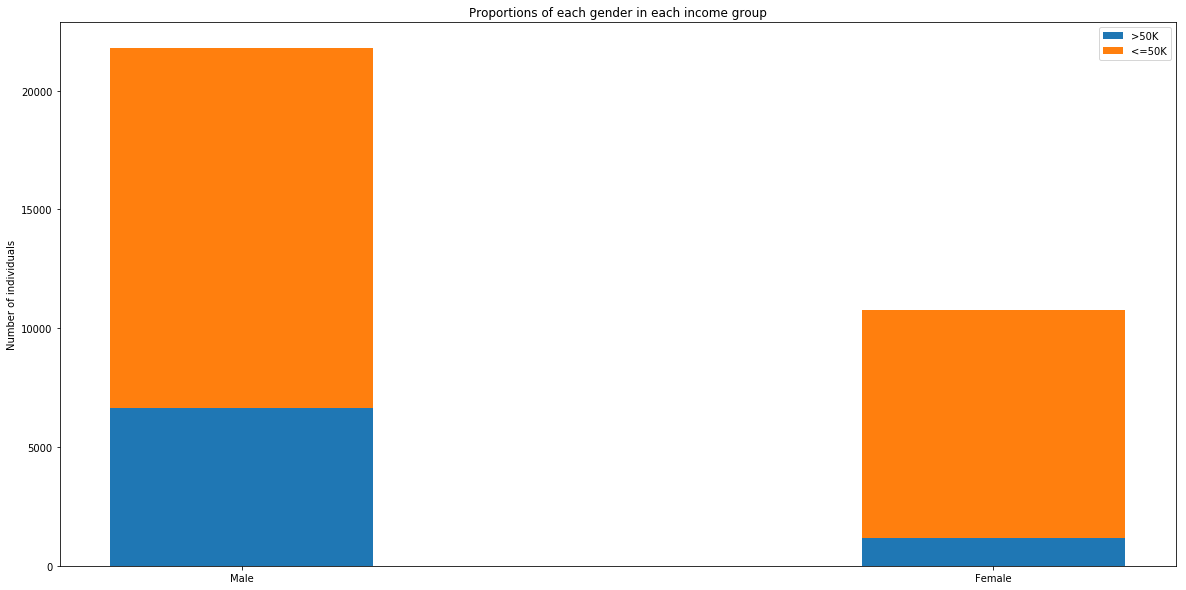

In [8]:
def countGroupOfGroups(topGroupName, subGroupName):
    """Divide the dataset using two of its attributes, return a dictionary containing the nested counts of samples
    that fall into each group"""
    
    topCategories = dict()

    for topKey in dataset[topGroupName].unique():
        subcategories = dict()
        subgroup = dataset[dataset[topGroupName] == topKey]
        
        for subKey in subgroup[subGroupName].unique():
            subcategories[str(subKey)] = int(subgroup[subgroup[subGroupName] == subKey].shape[0])

        topCategories[str(topKey)] = subcategories
    
    return topCategories

# Plot how income is divided by gender
genderCategories = countGroupOfGroups("income", "sex")
print(genderCategories)

ind = np.arange(len(genderCategories["<=50K"])) 
barWidth = 0.35

plt.subplots(figsize=(20, 10))
p1 = plt.bar(ind, genderCategories[">50K"].values(), barWidth)
p2 = plt.bar(ind, genderCategories["<=50K"].values(), barWidth, bottom=genderCategories[">50K"].values())

plt.ylabel('Number of individuals')
plt.title('Proportions of each gender in each income group')
plt.xticks(ind, genderCategories["<=50K"].keys())
plt.legend((p1[0], p2[0]), [">50K", "<=50K"])
plt.show()

More individuals in the dataset earn <=50k than >50k, and there are more men than women in the dataset. The proportion of women earning >50k is significantly smaller than the proportion of women earning <=50k. 

{'<=50K': {'Asian-Pac-Islander': 763, 'Amer-Indian-Eskimo': 275, 'Black': 2737, 'White': 20699, 'Other': 246}, '>50K': {'Asian-Pac-Islander': 276, 'Other': 25, 'Black': 387, 'White': 7117, 'Amer-Indian-Eskimo': 36}}


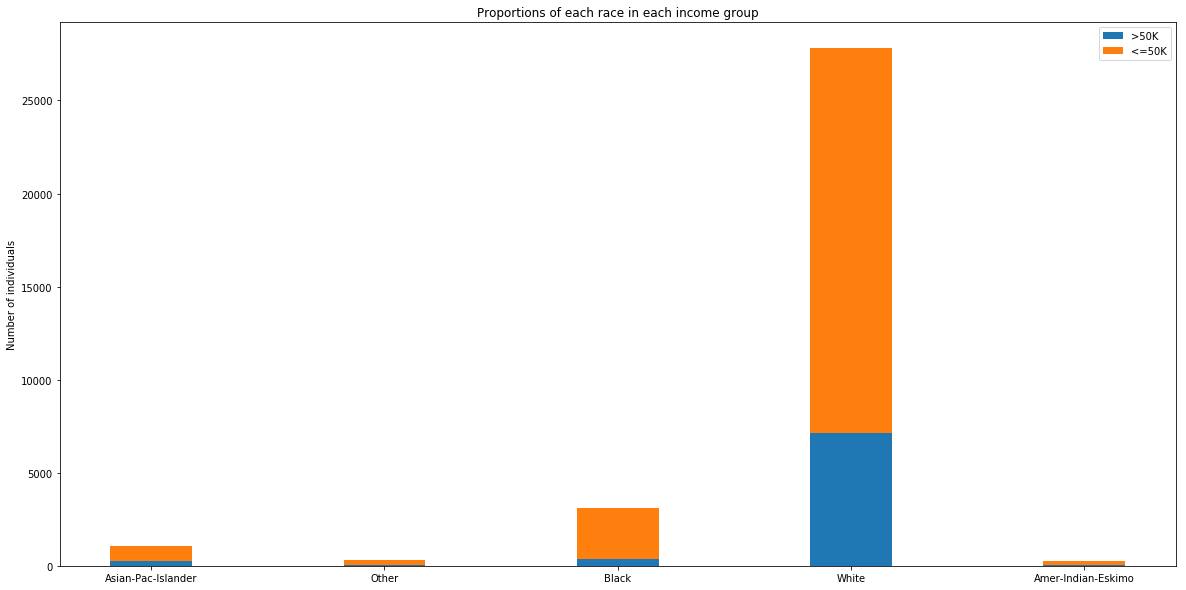

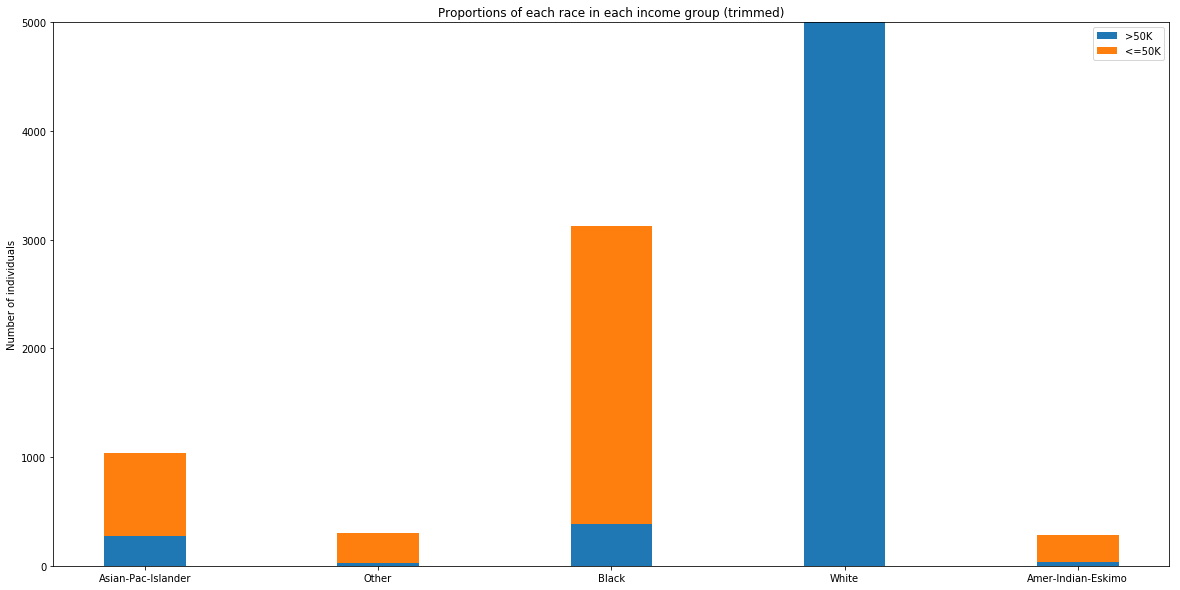

In [9]:
# Plot how income is divided by race
raceCategories = countGroupOfGroups("income", "race")
print(raceCategories)

ind = np.arange(len(raceCategories[">50K"])) 
barWidth = 0.35

plt.subplots(figsize=(20, 10))
p1 = plt.bar(ind, raceCategories[">50K"].values(), barWidth)
p2 = plt.bar(ind, raceCategories["<=50K"].values(), barWidth, bottom=raceCategories[">50K"].values())

plt.ylabel('Number of individuals')
plt.title('Proportions of each race in each income group')
plt.xticks(ind, raceCategories[">50K"].keys())
plt.legend((p1[0], p2[0]), [">50K", "<=50K"])
plt.show()

# Plot the same thing again, but trim the y axis so that some areas of the graph are more visible
plt.subplots(figsize=(20, 10))
p1 = plt.bar(ind, raceCategories[">50K"].values(), barWidth)
p2 = plt.bar(ind, raceCategories["<=50K"].values(), barWidth, bottom=raceCategories[">50K"].values())

plt.ylabel('Number of individuals')
plt.title('Proportions of each race in each income group (trimmed)')
plt.xticks(ind, raceCategories[">50K"].keys())
plt.legend((p1[0], p2[0]), [">50K", "<=50K"])
plt.ylim([0, 5000])
plt.show()

Across all races more individuals earn <=50k than >50k, compared to other races a higher proportion of white individuals earn >50k than <=50k.

## Prepare the test set

First we'll set aside the training set and encode the labels. <=50k will be encoded to 0.

In [10]:
X = dataset.drop("income", axis=1)
y = dataset["income"]

y_binarizer = LabelBinarizer()
y = y_binarizer.fit_transform(y).ravel()

print("X:\n", X.head(5))
print()
print("y:\n", y[0:5])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X:
    age workclass  fnlwgt     education  education.num marital.status  \
0   90         ?   77053       HS-grad              9        Widowed   
1   82   Private  132870       HS-grad              9        Widowed   
2   66         ?  186061  Some-college             10        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   

          occupation   relationship   race     sex  capital.gain  \
0                  ?  Not-in-family  White  Female             0   
1    Exec-managerial  Not-in-family  White  Female             0   
2                  ?      Unmarried  Black  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   

   capital.loss  hours.per.week native.country  
0          4356              40  United-States  
1          4356              18  United-States  
2      

Now we're going to build the preparation pipeline. We'll use two pipelines in parallel, one for numerical features and another for categorical features.

The categorical features will be one-hot encoded using a LabelBinarizer for sklearn (this isn't exactly what this class is intended for, but this is the best way I've found to achieve the desired result).

The numerical features will be scaled using StandardScaler.

In [11]:
NUMERICAL_FEATURES = list()
CATEGORICAL_FEATURES = list()

for featureNumber in range(X.values.shape[1]):
    if type(dataset.values[0, featureNumber]) is str:
        CATEGORICAL_FEATURES.append(dataset.columns.values[featureNumber])
    else:
        NUMERICAL_FEATURES.append(dataset.columns.values[featureNumber])

print("Numerical features:", NUMERICAL_FEATURES)
print()
print("Categorical features:", CATEGORICAL_FEATURES)

class FeatureSeparator(BaseEstimator, TransformerMixin): 
    """Class will drop features that do not match the provided names."""
    _featureNames = list()
    
    def __init__(self, featureNames):
        self._featureNames = featureNames

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self._featureNames].values

    
class MultiFeatureBinarizer(BaseEstimator, TransformerMixin):
    """Perform the binarization for each feature, returning a large matrix of all features."""
    _binarizers = list()
    
    def  __init__(self):
        return None
    
    def fit(self, X, y=None):
        """Builds and fits a list of LabelBinarizers, one for each feature"""
        NUM_FEATURES = X.shape[1]
        
        for featureNumber in range(NUM_FEATURES):
            binarizer = LabelBinarizer()
            binarizer.fit(X[:, featureNumber])
            self._binarizers.append(binarizer)
        
        return self
            
        
    def transform(self, X):
        """Performs the binarization and returns a matrix of all the new binary features."""
        retVal = np.empty((0, 0))
        
        for featureNumber in range(len(self._binarizers)):
            if (featureNumber == 0):
                retVal = self._binarizers[featureNumber].transform(X[:, featureNumber])
            else:
                retVal = np.concatenate((retVal, self._binarizers[featureNumber].transform(X[:, featureNumber])),
                                        axis=1)

        return retVal

    

numPipeline = Pipeline([ ('selector', FeatureSeparator(NUMERICAL_FEATURES)),
                         ('std_scaler', StandardScaler()) ])

catPipeline = Pipeline([ ('selector', FeatureSeparator(CATEGORICAL_FEATURES)),
                         ('multi_binarizer', MultiFeatureBinarizer()) ])

prepPipeline = FeatureUnion(transformer_list=[
    ('num_pipeline', numPipeline),
    ('cat_pipeline', catPipeline)
])

X_train_prepared = prepPipeline.fit_transform(X_train)

print("First row of our prepared dataset:\n", X_train_prepared[0, :])
print("Samples, Features:", X_train_prepared.shape)

Numerical features: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

Categorical features: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']


/Users/jack/anaconda3/envs/mlEnv_py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


First row of our prepared dataset:
 [-0.63111667 -0.31341    -0.42213798 -0.14637969 -0.21876864  0.37278899
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.          1.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          1.          1.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.    

Now we can train a random forest to assess feature importance

In [12]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X_train_prepared, y_train)

featureImportances = dict()
for name, score in zip(dataset.columns.values, rnd_clf.feature_importances_):
    featureImportances[name] = score
    
importancesSortedKeys = sorted(featureImportances,
                               key=featureImportances.get,
                               reverse=True)

print("Feature importance:")
for key in importancesSortedKeys:
    print(key, featureImportances[key])

Feature importance:
workclass 0.159058423154
age 0.146601378171
education 0.0968875494776
marital.status 0.082349440639
fnlwgt 0.0639353491778
education.num 0.0314844378286
capital.gain 0.0105877895491
hours.per.week 0.00841163704182
capital.loss 0.00613049887405
race 0.00582699069359
relationship 0.00530832465266
native.country 0.00452705583872
occupation 0.00186428402523
income 6.8190345772e-05
sex 1.29632437062e-06


## Training Models

Now that we've done some basic data preparation, we'll do a grid search of a few different models to see which are most promising

In [13]:
class Model:
    classifier = None
    gridSearch = None
    
    def __init__(self, classifier, paramGrid):
        self.classifier = classifier
    
        self.gridSearch = GridSearchCV(self.classifier,
                                      paramGrid,
                                      cv=5,
                                      scoring="accuracy",
                                      verbose=2,
                                      n_jobs=-1)
        

        
        

# Create a dictionary of classifiers and grid search parameters
classifiers = dict()
classifiers["knn"] = Model(KNeighborsClassifier(),
                           [ {'n_jobs': [-1], 'n_neighbors': [2, 4, 6]} ])

classifiers["randomForest"] = Model(RandomForestClassifier(),
                                    [ {'n_jobs': [-1], 'n_estimators': [10, 100, 500]},
                                      {'n_jobs': [-1], 'n_estimators': [100], 'max_depth': [2, 20, 100]} ])

classifiers["sgd"] = Model(SGDClassifier(),
                           [ {"loss": ["hinge", "log"], 'penalty': ["l2", "l1"]} ])

classifiers["linearSVC"] = Model(LinearSVC(),
                                 [ {"C": [0.1, 1, 10]} ])

classifiers["rbfSVC"] = Model(SVC(),
                              [ {"C": [0.1, 1, 10], "kernel": ["rbf"]},
                                {"C": [0.1, 1, 10], "kernel": ["poly"], "degree": [2, 3]}])

classifiers["adaboost"] = Model(AdaBoostClassifier(),
                                [ {"n_estimators": [10, 50, 150], "learning_rate": [0.1, 1]}])

Perform the grid search of each model (each is in a separate cell so they can be ran individually)

In [14]:
classifiers["knn"].gridSearch.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_jobs=-1, n_neighbors=2 ........................................
[CV] n_jobs=-1, n_neighbors=2 ........................................
[CV] n_jobs=-1, n_neighbors=2 ........................................
[CV] n_jobs=-1, n_neighbors=2 ........................................
[CV] n_jobs=-1, n_neighbors=2 ........................................
[CV] n_jobs=-1, n_neighbors=4 ........................................
[CV] n_jobs=-1, n_neighbors=4 ........................................
[CV] n_jobs=-1, n_neighbors=4 ........................................
[CV] ............................... n_jobs=-1, n_neighbors=2 -  11.3s
[CV] n_jobs=-1, n_neighbors=4 ........................................
[CV] ............................... n_jobs=-1, n_neighbors=2 -  13.3s
[CV] n_jobs=-1, n_neighbors=4 ........................................
[CV] ............................... n_jobs=-1, n_neighbors=2 -  13.2s
[CV] n_jobs=-1, n

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.4min remaining:  1.2min


[CV] ............................... n_jobs=-1, n_neighbors=4 -  14.6s
[CV] ............................... n_jobs=-1, n_neighbors=4 -  15.1s
[CV] ............................... n_jobs=-1, n_neighbors=6 -  15.8s
[CV] ............................... n_jobs=-1, n_neighbors=6 -  15.9s
[CV] ............................... n_jobs=-1, n_neighbors=6 -  14.8s
[CV] ............................... n_jobs=-1, n_neighbors=6 -  16.7s
[CV] ............................... n_jobs=-1, n_neighbors=6 -  17.5s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_jobs': [-1], 'n_neighbors': [2, 4, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [15]:
classifiers["randomForest"].gridSearch.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] n_estimators=10, n_jobs=-1 ......................................
[CV] n_estimators=10, n_jobs=-1 ......................................
[CV] n_estimators=10, n_jobs=-1 ......................................
[CV] n_estimators=10, n_jobs=-1 ......................................
[CV] n_estimators=10, n_jobs=-1 ......................................
[CV] n_estimators=100, n_jobs=-1 .....................................
[CV] n_estimators=100, n_jobs=-1 .....................................
[CV] n_estimators=100, n_jobs=-1 .....................................
[CV] ............................. n_estimators=10, n_jobs=-1 -   0.2s
[CV] n_estimators=100, n_jobs=-1 .....................................
[CV] ............................. n_estimators=10, n_jobs=-1 -   0.1s
[CV] n_estimators=100, n_jobs=-1 .....................................
[CV] ............................. n_estimators=10, n_jobs=-1 -   0.1s
[CV] ............

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   32.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [10, 100, 500], 'n_jobs': [-1]}, {'n_estimators': [100], 'n_jobs': [-1], 'max_depth': [2, 20, 100]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [16]:
classifiers["sgd"].gridSearch.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] loss=hinge, penalty=l2 ..........................................
[CV] loss=hinge, penalty=l2 ..........................................
[CV] loss=hinge, penalty=l2 ..........................................
[CV] loss=hinge, penalty=l2 ..........................................
[CV] ................................. loss=hinge, penalty=l2 -   0.0s
[CV] ................................. loss=hinge, penalty=l2 -   0.0s
[CV] loss=hinge, penalty=l2 ..........................................
[CV] ................................. loss=hinge, penalty=l2 -   0.0s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] ................................. loss=hinge, penalty=l2 -   0.0s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] ................................. loss=hinge, penalty=l2 -   0.0s
[CV] loss=hinge, penalty=l1 ..........................................
[CV] loss=hinge, 

[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.0s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'loss': ['hinge', 'log'], 'penalty': ['l2', 'l1']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [17]:
classifiers["linearSVC"].gridSearch.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=0.1 ...........................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] C=1 .............................................................
[CV] .................................................. C=0.1 -   0.0s
[CV] C=1 .............................................................
[CV] .................................................. C=0.1 -   0.0s
[CV] C=1 .............................................................
[CV] .................................................. C=0.1 -   0.0s
[CV] C=10 .......

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    3.2s remaining:    2.8s


[CV] .................................................... C=1 -   0.0s
[CV] .................................................... C=1 -   0.0s
[CV] ................................................... C=10 -   0.0s
[CV] ................................................... C=10 -   0.0s
[CV] ................................................... C=10 -   0.0s
[CV] ................................................... C=10 -   0.0s
[CV] ................................................... C=10 -   0.0s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.5s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.1, 1, 10]}], pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='accuracy', verbose=2)

In [18]:
classifiers["rbfSVC"].gridSearch.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] C=0.1, kernel=rbf ...............................................
[CV] C=0.1, kernel=rbf ...............................................
[CV] C=0.1, kernel=rbf ...............................................
[CV] C=0.1, kernel=rbf ...............................................
[CV] C=0.1, kernel=rbf ...............................................
[CV] C=1, kernel=rbf .................................................
[CV] C=1, kernel=rbf .................................................
[CV] C=1, kernel=rbf .................................................
[CV] ........................................ C=1, kernel=rbf -   7.9s
[CV] C=1, kernel=rbf .................................................
[CV] ........................................ C=1, kernel=rbf -   7.9s
[CV] C=1, kernel=rbf .................................................
[CV] ........................................ C=1, kernel=rbf -   8.0s
[CV] C=10, kernel

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.7min


[CV] ............................. degree=2, C=1, kernel=poly -   8.8s
[CV] degree=3, C=1, kernel=poly ......................................
[CV] ........................... degree=3, C=0.1, kernel=poly -   9.8s
[CV] degree=3, C=1, kernel=poly ......................................
[CV] ............................. degree=2, C=1, kernel=poly -   8.4s
[CV] degree=2, C=10, kernel=poly .....................................
[CV] ............................. degree=2, C=1, kernel=poly -   8.3s
[CV] degree=2, C=10, kernel=poly .....................................
[CV] ............................. degree=2, C=1, kernel=poly -   8.3s
[CV] degree=2, C=10, kernel=poly .....................................
[CV] ............................. degree=3, C=1, kernel=poly -   9.3s
[CV] degree=2, C=10, kernel=poly .....................................
[CV] ............................. degree=3, C=1, kernel=poly -   9.1s
[CV] degree=2, C=10, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  9.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'C': [0.1, 1, 10]}, {'degree': [2, 3], 'kernel': ['poly'], 'C': [0.1, 1, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [19]:
classifiers["adaboost"].gridSearch.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] learning_rate=0.1, n_estimators=10 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ..................... learning_rate=0.1, n_estimators=10 -   0.0s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ..................... learning_rate=0.1, n_estimators=10 -   0.0s
[CV] learning_rate=0.1, n_estimators=50 ..............................
[CV] ..................... learning_rate=0.1, n_estimators=10 -   0.0s
[CV] learning_rat

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   21.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'learning_rate': [0.1, 1], 'n_estimators': [10, 50, 150]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

### Initial Results
Now we can inspect the results of the grid searches of each model

In [20]:
for key in classifiers.keys():
    print("\nFor classifier:", key)
    print(classifiers[key].gridSearch.best_estimator_)
    print("Accuracy:", classifiers[key].gridSearch.best_score_)


For classifier: randomForest
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy: 0.861448095823

For classifier: sgd
SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l1', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Accuracy: 0.84160012285

For classifier: rbfSVC
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  

### Tuning Models
The random forest, adaboost, and SVCs show the most promising results, and should be investigated further.

In [21]:
classifiers["randomForest"] = Model(RandomForestClassifier(),
                                    [ {'n_jobs': [-1], 'n_estimators': [90, 100, 110], 'max_depth': [15, 20, 25]} ])

classifiers["rbfSVC"] = Model(SVC(),
                              [ {"C": [9, 10, 11], "kernel": ["rbf"]} ])

classifiers["adaboost"] = Model(AdaBoostClassifier(),
                                [ {"n_estimators": [150, 200, 300]} ])

classifiers["randomForest"].gridSearch.fit(X_train_prepared, y_train)
classifiers["rbfSVC"].gridSearch.fit(X_train_prepared, y_train)
classifiers["adaboost"].gridSearch.fit(X_train_prepared, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] max_depth=15, n_jobs=-1, n_estimators=90 ........................
[CV] max_depth=15, n_jobs=-1, n_estimators=90 ........................
[CV] max_depth=15, n_jobs=-1, n_estimators=90 ........................
[CV] max_depth=15, n_jobs=-1, n_estimators=90 ........................
[CV] max_depth=15, n_jobs=-1, n_estimators=90 ........................
[CV] max_depth=15, n_jobs=-1, n_estimators=100 .......................
[CV] max_depth=15, n_jobs=-1, n_estimators=100 .......................
[CV] max_depth=15, n_jobs=-1, n_estimators=100 .......................
[CV] ............... max_depth=15, n_jobs=-1, n_estimators=90 -   0.2s
[CV] max_depth=15, n_jobs=-1, n_estimators=100 .......................
[CV] ............... max_depth=15, n_jobs=-1, n_estimators=90 -   0.2s
[CV] ............... max_depth=15, n_jobs=-1, n_estimators=90 -   0.2s
[CV] max_depth=15, n_jobs=-1, n_estimators=100 .......................
[CV] max_depth=15

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.9s


[CV] .............. max_depth=20, n_jobs=-1, n_estimators=110 -   0.2s
[CV] max_depth=25, n_jobs=-1, n_estimators=90 ........................
[CV] .............. max_depth=20, n_jobs=-1, n_estimators=110 -   0.3s
[CV] max_depth=25, n_jobs=-1, n_estimators=90 ........................
[CV] .............. max_depth=20, n_jobs=-1, n_estimators=110 -   0.2s
[CV] max_depth=25, n_jobs=-1, n_estimators=100 .......................
[CV] .............. max_depth=20, n_jobs=-1, n_estimators=110 -   0.2s
[CV] max_depth=25, n_jobs=-1, n_estimators=100 .......................
[CV] ............... max_depth=25, n_jobs=-1, n_estimators=90 -   0.2s
[CV] ............... max_depth=25, n_jobs=-1, n_estimators=90 -   0.2s
[CV] max_depth=25, n_jobs=-1, n_estimators=100 .......................
[CV] max_depth=25, n_jobs=-1, n_estimators=100 .......................
[CV] .............. max_depth=20, n_jobs=-1, n_estimators=110 -   0.2s
[CV] max_depth=25, n_jobs=-1, n_estimators=100 .......................
[CV] .

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   30.5s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] C=9, kernel=rbf .................................................
[CV] C=9, kernel=rbf .................................................
[CV] C=9, kernel=rbf .................................................
[CV] C=9, kernel=rbf .................................................
[CV] C=9, kernel=rbf .................................................
[CV] C=10, kernel=rbf ................................................
[CV] C=10, kernel=rbf ................................................
[CV] C=10, kernel=rbf ................................................
[CV] ........................................ C=9, kernel=rbf -   7.6s
[CV] ....................................... C=10, kernel=rbf -   7.6s
[CV] C=10, kernel=rbf ................................................
[CV] C=10, kernel=rbf ................................................
[CV] ........................................ C=9, kernel=rbf -   7.7s
[CV] C=11, kernel

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.6min remaining:  1.4min


[CV] ....................................... C=10, kernel=rbf -   7.1s
[CV] ....................................... C=10, kernel=rbf -   7.1s
[CV] ....................................... C=11, kernel=rbf -   7.1s
[CV] ....................................... C=11, kernel=rbf -   7.1s
[CV] ....................................... C=11, kernel=rbf -   7.0s
[CV] ....................................... C=11, kernel=rbf -   7.1s
[CV] ....................................... C=11, kernel=rbf -   7.1s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.0min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=150 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=200 ................................................
[CV] n_estimators=200 ................................................
[CV] ....................................... n_estimators=150 -   0.2s
[CV] n_estimators=200 ................................................
[CV] ....................................... n_estimators=150 -   0.2s
[CV] ....................................... n_estimators=150 -   0.2s
[CV] n_estimators=200 ................................................
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:   13.0s remaining:   11.4s


[CV] ....................................... n_estimators=200 -   0.3s
[CV] ....................................... n_estimators=200 -   0.3s
[CV] ....................................... n_estimators=300 -   0.3s
[CV] ....................................... n_estimators=300 -   0.3s
[CV] ....................................... n_estimators=300 -   0.3s
[CV] ....................................... n_estimators=300 -   0.3s
[CV] ....................................... n_estimators=300 -   0.3s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   28.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [150, 200, 300]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=2)

In [22]:
for key in list(["randomForest", "rbfSVC", "adaboost"]): 
    print("\nFor classifier:", key)
    print(classifiers[key].gridSearch.best_estimator_)
    print("Accuracy:", classifiers[key].gridSearch.best_score_)


For classifier: randomForest
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)
Accuracy: 0.86129453317

For classifier: rbfSVC
SVC(C=9, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy: 0.854077088452

For classifier: adaboost
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=300, random_state=None)
Accuracy: 0.869471744472


Adaboost is now starting to extend a small lead over the random forest and RBF SVC models, and I think has room to be optimised further, but before doing so let's look into the results we have so far.

87% isn't particularly great, especially as a classifier which always outputs "<=50k" would get a little over 75% accuracy on this dataset. There is also potentially a lot of overlap between the two classes which will make things more difficult and limit the accuracy that can be achieved.

Let's create a confusion matrix for our models to see if this offers any clues as to where we could do better.

In [23]:
y_pred_forest = classifiers["randomForest"].gridSearch.predict(X_train_prepared)
y_pred_rbfSVC = classifiers["rbfSVC"].gridSearch.predict(X_train_prepared)
y_pred_adaboost = classifiers["adaboost"].gridSearch.predict(X_train_prepared)

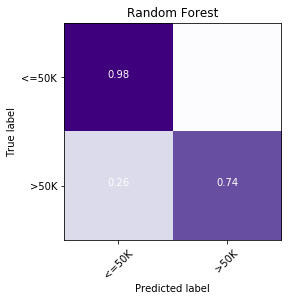

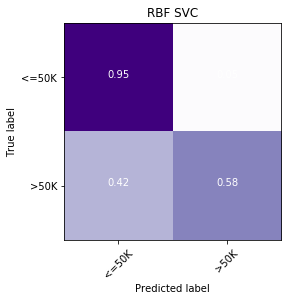

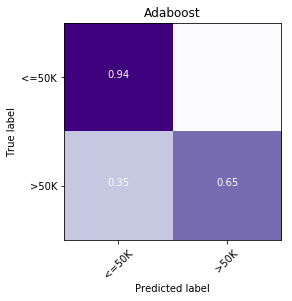

In [24]:
def plotConfusionMatrix(confusionMatrix, title, classNames):
    """Normalises and plots a grid of the confusion matrix (mostly borrowed from an sklearn tutorial)"""
    
    # Scale it, plot the coloured grid
    confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Purples)
    
    
    # Labels
    plt.title(title)
    tickMarks = np.arange(len(classNames))
    plt.xticks(tickMarks, classNames, rotation=45)
    plt.yticks(tickMarks, classNames)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Plot the numbers
    for i, j in itertools.product(range(confusionMatrix.shape[0]), range(confusionMatrix.shape[1])):
        plt.text(j, i, format(confusionMatrix[i, j], ".2f"),
                 horizontalalignment="center",
                 color="white")

    

plotConfusionMatrix(confusion_matrix(y_train, y_pred_forest), "Random Forest", ["<=50K", ">50K"])
plt.show()

plotConfusionMatrix(confusion_matrix(y_train, y_pred_rbfSVC), "RBF SVC", ["<=50K", ">50K"])
plt.show()

plotConfusionMatrix(confusion_matrix(y_train, y_pred_adaboost), "Adaboost", ["<=50K", ">50K"])
plt.show()

As suspected, it looks like our models are leaning a little too heavily on the assumption that most people earn <=50k, and so is frequently classifying instances in this category incorrectly. The Random Forest does appear to perform slightly better in this regard.

For now we'll keep grid searching on Adaboost, since it looks like there is room to continue improving.

(I ran multiple grid searches on Adaboost to close in on the optimal configuration, for brevity I've included only the final grid search below)

In [25]:
classifiers["adaboost"] = Model(AdaBoostClassifier(),
                                [ {"n_estimators": [1450, 1500, 1700]}])
classifiers["adaboost"].gridSearch.fit(X_train_prepared, y_train)

print(classifiers["adaboost"].gridSearch.best_estimator_)
print("Accuracy:", classifiers["adaboost"].gridSearch.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] n_estimators=1450 ...............................................
[CV] n_estimators=1450 ...............................................
[CV] n_estimators=1450 ...............................................
[CV] n_estimators=1450 ...............................................
[CV] n_estimators=1450 ...............................................
[CV] n_estimators=1500 ...............................................
[CV] n_estimators=1500 ...............................................
[CV] n_estimators=1500 ...............................................
[CV] ...................................... n_estimators=1450 -   2.6s
[CV] ...................................... n_estimators=1450 -   2.5s
[CV] n_estimators=1500 ...............................................
[CV] n_estimators=1500 ...............................................
[CV] ...................................... n_estimators=1450 -   2.4s
[CV] n_estimators

[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:  1.7min remaining:  1.5min


[CV] ...................................... n_estimators=1500 -   2.1s
[CV] ...................................... n_estimators=1500 -   2.1s
[CV] ...................................... n_estimators=1700 -   1.9s
[CV] ...................................... n_estimators=1700 -   1.9s
[CV] ...................................... n_estimators=1700 -   1.9s
[CV] ...................................... n_estimators=1700 -   1.8s
[CV] ...................................... n_estimators=1700 -   1.9s


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.5min finished


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=1500, random_state=None)
Accuracy: 0.870738636364


It would appear that we're pretty close to the optimum number of estimators. Since this is only ~0.001 improvement in accuracy, depending on the use case for the model it might not be worth the extra time taken to train and predict with the additional number of estimators.

If we plot another confusion matrix, it appears that the number of instances which are incorrectly predicted as <=50k has reduced slightly.

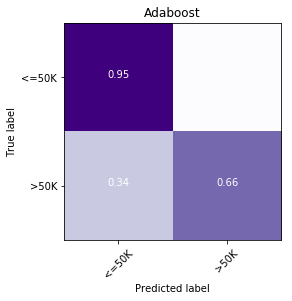

In [26]:
y_pred_adaboost = classifiers["adaboost"].gridSearch.predict(X_train_prepared)
plotConfusionMatrix(confusion_matrix(y_train, y_pred_adaboost), "Adaboost", ["<=50K", ">50K"])
plt.show()

### Test Performance
As the final step, we'll now see how our model has performed on the test set that we set aside earlier.

In [31]:
X_test_prepared = prepPipeline.transform(X_test)
y_test_predictions = classifiers["adaboost"].gridSearch.predict(X_test_prepared)
print(accuracy_score(y_test, y_test_predictions))

/Users/jack/anaconda3/envs/mlEnv_py35/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


0.867035160448


So the accuracy on the test set is 86.7%, a little lower than the validation accuracy but still reasonably close.